In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors # for plot color gradients
import glob
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from scipy.optimize import minimize, basinhopping, differential_evolution


from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter, landscape
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF
import os
# Define the title for the entire PDF
pdf_title = "15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13"
# Define the base directory
base_dir = '/home/jwm/data/fluorescence_plots/'
# Construct the figure directory path
figure_dir = os.path.join(base_dir, pdf_title)
# Ensure the figure directory exists
os.makedirs(figure_dir, exist_ok=True)# Directory for joined pdfs
# Directory for joined pdfs
output_dir = '/home/jwm/data/fluorescence_plots/fluorescence_data_overview_21_may_2024/'
os.makedirs(output_dir, exist_ok=True)



In [24]:
# Load and organize data, set parameters and choose subset

# Set the directory where your data files are located
data_dir = '/home/jwm/data/JASCO_FP_6500_Spectrofluorometer/2024april13_50mM_DAB2_418_630_150mM_NaCl_1DCVJ_slow_hysteresis/'

start_temperature = 10

temperature_stepsize = 0.5



# Define the range of titles you want to load
# start_title = 7
# end_title = 30

# Function to load (x, y) data from txt file starting from the 19th line
def load_data(file_path):
    return np.loadtxt(file_path, skiprows=18)

# Get all txt files in the directory
data_files = glob.glob(data_dir + "*.txt")

# Initialize a list to store loaded data
loaded_data = []

# Initialize variables for baseline data
baseline_data = None
baseline_title = None

titles = []

# Load data and extract titles
for file_path in data_files:
    data = load_data(file_path)
    # Check if file name contains "999" and assign it as baseline data
    if "999" in file_path:
        baseline_data = data
    else:
        # Extract 6th to 4th last digits from file name and use as title
        title = int(file_path.split('/')[-1].split('.')[0][-7:-4])
        titles.append(title)
        loaded_data.append(data)
        
# Print the baseline title to check if it is set correctly
print("Baseline data loaded:", baseline_data is not None)

# Subtract the baseline spectrum from each spectrum if baseline_data is available
if baseline_data is not None:
    baseline_spectrum = baseline_data[:, 1]  # Assuming y-values are in the second column
    for i in range(len(loaded_data)):
        loaded_data[i][:, 1] -= baseline_spectrum

# Sort the titles and loaded_data in ascending order
sorted_indices = np.argsort(titles)
titles = [titles[i] for i in sorted_indices]
loaded_data = [loaded_data[i] for i in sorted_indices]

# Print sorted titles to verify sorting
print("Sorted titles:", titles)

# Convert extracted digits back to temperature values
temperatures = [start_temperature + i * temperature_stepsize for i in range(len(titles))]

# Extract x-values from the first spectrum in loaded_data
wavelengths = loaded_data[0][:, 0].astype(float)

print(wavelengths)

# Sample loaded_data structure
# loaded_data = [
#    np.array([[470.0, 422.133], [470.1, 422.08], [470.2, 422.001], [650.0, 7.49391]]),
#    np.array([[470.0, 430.678], [470.1, 430.75], [470.2, 430.611], [650.0, 7.97855]])
#]

# Function to create DataFrame
def create_dataframe(loaded_data, titles):  # spectra in rows
    # Initialize DataFrame with the first spectrum
    df = pd.DataFrame(loaded_data[0], columns=['wavelength', titles[0]])
    
    # Iterate over the remaining spectra and concatenate them to the DataFrame
    for i in range(1, len(loaded_data)):
        spectrum_df = pd.DataFrame(loaded_data[i], columns=['wavelength', titles[i]])
        df = pd.merge(df, spectrum_df, on='wavelength', how='outer')
    
    return df

# selected_data = [loaded_data[titles.index(title)] for title in included_titles]

title_inputs = input("Enter the titles to include (separated by space), and ranges separated by '-': ").split()
included_titles = [title for title_input in title_inputs for title in (list(range(int(title_input.split('-')[0]), int(title_input.split('-')[-1])+1)) if '-' in title_input else [int(title_input)])]

def get_selected_data(loaded_data, titles_input):
    selected_data = []
    selected_temperatures = []
    for title_input in titles_input:
        if '-' in str(title_input):
            start, end = map(int, title_input.split('-'))
            selected_data.extend(loaded_data[start-1:end])
            selected_temperatures.extend(temperatures[start-1:end])
        else:
            selected_data.append(loaded_data[int(title_input)-1])
 #           selected_temperatures.append(temperatures[int(title_input)-1])
    return selected_data, selected_temperatures
    
selected_data, selected_temperatures = get_selected_data(loaded_data, included_titles)

df = create_dataframe(selected_data, included_titles)
df = df.transpose()
print(df)



Baseline data loaded: True
Sorted titles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 100]
[470.  470.1 470.2 ... 649.8 649.9 650. ]


Enter the titles to include (separated by space), and ranges separated by '-':  1-45


               0        1        2        3        4        5        6     \
wavelength  470.000  470.100  470.200  470.300  470.400  470.500  470.600   
1           120.254  120.547  120.952  122.227  122.539  124.786  126.108   
2           128.799  129.217  129.562  130.126  131.033  132.968  134.314   
3           148.973  149.599  149.811  150.296  150.950  153.083  153.082   
4           179.545  179.431  179.918  180.942  181.789  183.595  184.277   
5           205.592  205.307  205.286  205.884  206.314  207.546  208.689   
6           225.090  225.038  225.668  225.446  225.762  227.169  228.132   
7           195.168  194.703  195.052  195.043  195.302  197.082  198.064   
8           198.170  198.196  198.376  198.953  198.193  199.976  200.440   
9           161.292  161.528  161.809  162.295  162.335  164.219  163.983   
10          118.461  117.889  117.955  118.942  118.885  120.209  121.335   
11           81.717   81.959   81.893   82.294   81.857   82.903   83.316   

/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/1_raw_spectra.svg


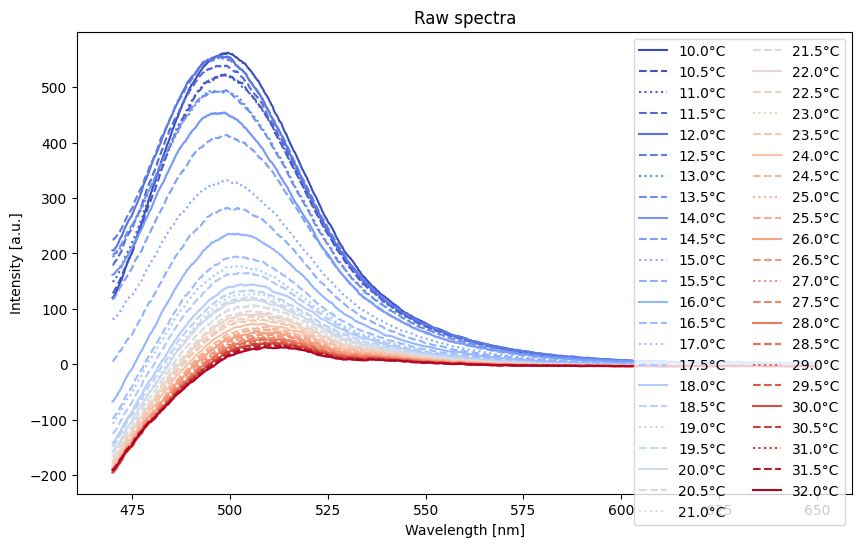

/home/jwm/data/fluorescence_plots/15h_up_50mM_DAB2_150mM_NaCl_1DCVJ_2024april13/2_single_wavelength_dynamics.svg


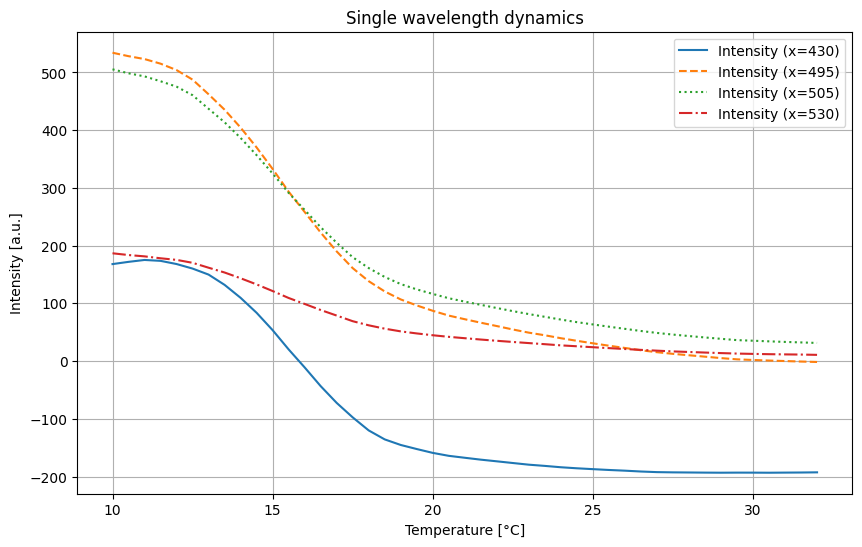

<module 'matplotlib.pyplot' from '/home/jwm/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [33]:
dotting_patterns=['-', '--', ':', '--']

# Plot the plain spectra
def plot_projection_residuals(wavelengths, selected_data, selected_temperatures):
    colormap = plt.get_cmap('coolwarm')  # Or use 'RdBu' or a custom colormap
    norm = mcolors.Normalize(vmin=min(selected_temperatures), vmax=max(selected_temperatures))
    
    plt.figure(figsize=(10, 6))
    labels_shown = set()  # Track labels to avoid duplication

 
    for i, temp in enumerate(selected_temperatures):
        color = colormap(norm(temp))
        line_style = dotting_patterns[i % len(dotting_patterns)]  # Cycle through dotting patterns
        label = f'{selected_temperatures[i]}°C'
        
        if label not in labels_shown:
            plt.plot(wavelengths, selected_data[i][:, 1], label=label, color=color, linestyle=line_style)
            labels_shown.add(label)
        else:
            plt.plot(wavelengths, selected_data[i][:, 1], color=color, linestyle=line_style)

    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Intensity [a.u.]')
    plt.legend(ncol=2)
    plt.title(f'Raw spectra')
    save_path = os.path.join(figure_dir, '1_raw_spectra.svg')
    print(save_path)
    plt.savefig(save_path)    

    plt.show()
    return plt

plot_projection_residuals(wavelengths, selected_data, selected_temperatures)

# Plot temperature changes for specific wavelengths

dotting_patterns2=['-', '--', ':', '-.']

# Define the four x-values
x_values = [430, 495, 505, 530]

# Initialize lists to store y-values for each x-value for all spectra
y_values_all = [[] for _ in range(len(x_values))]

# Reduce noise by averaging
for i, data in enumerate(selected_data):
    # Iterate through each specified x-value
    for j, x in enumerate(x_values):
        # Find the index of the closest x-value in the dataset
        closest_index = np.argmin(np.abs(data[:, 0] - x))
        # Extract the corresponding y-value
        y_value = data[closest_index, 1]
        # Store the y-value
        y_values_all[j].append(y_value)

def plot_single_wavelength_dynamics(wavelengths, selected_data, selected_temperatures):
    plt.figure(figsize=(10, 6))
    for i, x in enumerate(x_values):
        line_style = dotting_patterns2[i % len(dotting_patterns)]  # Cycle through dotting patterns
# Calculate mean of 5 surrounding points for each x-value
        mean_values = [np.mean(y_values_all[i][max(0, j-5):min(len(y_values_all[i]), j+6)]) for j in range(len(y_values_all[i]))]
# Plot data points
        plt.plot(selected_temperatures, mean_values, label=f'Intensity (x={x})', linestyle=line_style)

    plt.xlabel('Temperature [°C]')
    plt.ylabel('Intensity [a.u.]')
    plt.title('Single wavelength dynamics')
    plt.legend()

    plt.grid(True)
    save_path = os.path.join(figure_dir, '2_single_wavelength_dynamics.svg')
    print(save_path)
    plt.savefig(save_path)    

    plt.show()
    return plt

plot_single_wavelength_dynamics(wavelengths, selected_data, selected_temperatures)

